In [1]:
import numpy as np
from FlagRepp import FlagRepp
from matplotlib import pyplot as plt

import scipy.io as sio

from tqdm import tqdm

import pandas as pd

In [2]:
def relative_log_mse(D_rec, D_true):
    return 10*np.log10(np.linalg.norm(D_rec - D_true, 'fro')**2/(np.linalg.norm(D_true, 'fro')**2))

# Trying with HS data

In [3]:
fl_type = [8,9,10]
height, width = (50,50)
distributions = ['Normal', 'Exponential', 'Uniform']

In [ ]:
results = pd.DataFrame(columns = ['Method', 'SNR (dB)', 'Added Noise', 'LRSE', 'DataSet', 'Distribution'])

for data_name in ['KSC', 'Indian Pines']:
    if data_name == 'Indian Pines':
        # Load the hyperspectral image and ground truth
        data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 
        labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)
    elif data_name == 'KSC':
        data = sio.loadmat('../data/KSC/KSC_corrected.mat')['KSC']
        labels = sio.loadmat('../data/KSC/KSC_gt.mat')['KSC_gt']

    image_height, image_width, n_bands = data.shape
    
    As = [np.arange(40), np.arange(100), np.arange(n_bands)]

    for noise_dist in distributions:

        for noise_scale in tqdm(np.arange(1,20)):
            noise_scale = .1*noise_scale
            
            for r_seed in range(20):
                np.random.seed(r_seed)
                # Assume `image` is a NumPy array with shape (height, width, channels)
                
                # Define the crop size
                crop_height = height
                crop_width = width

                # Randomly select the starting point for the crop
                x_start = np.random.randint(0, image_width - crop_width + 1)
                y_start = np.random.randint(0, image_height - crop_height + 1)

                # Crop the image
                cropped_image = data[y_start:y_start + crop_height, x_start:x_start + crop_width]

                n = width*height
                D_true = cropped_image.reshape((width*height, n_bands))

                D_true = D_true/D_true.max() #max normalization

                if noise_dist == 'Normal':
                    noise = np.random.normal(scale = noise_scale, size = (n,n_bands))
                elif noise_dist == 'Exponential':
                    noise = np.random.exponential(scale = noise_scale, size = (n,n_bands))
                elif noise_dist == 'Uniform':
                    noise = noise_scale*np.random.uniform(size = (n,n_bands))

                D_noisy = D_true + noise

                snr = 10*np.log10(np.linalg.trace(D_true@D_true.T)/np.linalg.trace(noise@noise.T))

                U, _, _ = np.linalg.svd(D_noisy)
                D_svd = U[:,:fl_type[-1]] @ U[:,:fl_type[-1]].T @ D_noisy
                svd_lrse = relative_log_mse(D_svd,D_true)
                row = pd.DataFrame(columns = results.columns, data = [['SVD', snr, noise_scale, svd_lrse, data_name, noise_dist]])
                results = pd.concat([results, row])

                my_fr = FlagRepp(As, flag_type = fl_type)
                X,R = my_fr.fit_transform(D_noisy)
                D_flagrep = X @ R
                flagrep_lrse = relative_log_mse(D_flagrep,D_true)
                row = pd.DataFrame(columns = results.columns,  data = [['FD', snr, noise_scale, flagrep_lrse,  data_name, noise_dist]])
                results = pd.concat([results, row])


  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_407959/2996906833.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])
100%|██████████| 19/19 [01:01<00:00,  3.21s/it]


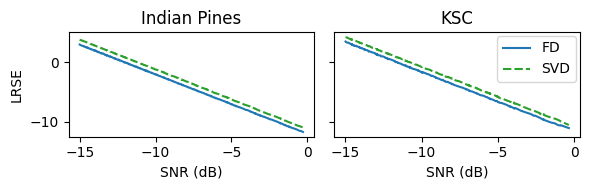

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
results = pd.read_csv('../results/HSI_denoising.csv')
results = results.replace({'FlagRep':'FD'})

normal_results = results[results['Distribution'] == 'Normal']
normal_results = normal_results[(normal_results['SNR (dB)'] < 0) & (normal_results['SNR (dB)'] > -15)]
normal_results = normal_results.sort_values(by = 'Method')

fig, ax = plt.subplots(1,2,  figsize = (6,2), sharey = True)

subset = normal_results[normal_results['DataSet'] == 'Indian Pines']
sns.lineplot(subset, x = 'SNR (dB)', y = 'LRSE', hue = 'Method', ax = ax[0], style = 'Method', palette = {'FD': 'tab:blue', 'SVD': 'tab:green'})
ax[0].set_title('Indian Pines')

subset = normal_results[normal_results['DataSet'] == 'KSC']
sns.lineplot(subset, x = 'SNR (dB)', y = 'LRSE', hue = 'Method', ax = ax[1], style = 'Method', palette = {'FD': 'tab:blue', 'SVD': 'tab:green'})
ax[1].set_title('KSC')


for a in ax.flat:
    a.legend_.remove()

# Get handles and labels from one of the axes
handles, labels = ax[0].get_legend_handles_labels()

# Add a single legend inside the figure
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(.98, 0.83), title="", prop={'size': 10})
plt.tight_layout()

# # Plot settings
# plt.rcParams.update({'font.size': 12})
# plt.figure(figsize=(6, 3))

# # Initialize the FacetGrid
# g = sns.FacetGrid(
#     normal_results,
#     col="DataSet",
#     hue="Method",
#     margin_titles=True,
#     despine=False,
#     palette={'FlagRep':'tab:blue', 'SVD':'tab:green'}
# )

# # Map the lineplot onto each subplot in the FacetGrid
# g.map(sns.regplot, "SNR (dB)", "LRSE", scatter=False)

# # Modify subplot titles by removing "DataSet=" prefix
# for ax in g.axes.flat:
#     title = ax.get_title().replace('DataSet = ', '')
#     ax.set_title(title)

# # Add legend and customize labels
# g.add_legend()
# g._legend.set_title('')  # Remove the legend title

# # Position the legend inside each subplot (adjust bbox_to_anchor as needed)
# g._legend.set_bbox_to_anchor((.45, 0.5))  # (x, y) with (0.05, 0.95) positioning in the top-left
# g._legend.set_loc("upper left")  # Anchor the legend at the top-left corner

# # Display and save the figure
plt.savefig('../results/RS_Reconstruction.pdf', bbox_inches='tight')


In [16]:
normal_results

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Method,SNR (dB),Added Noise,LRSE,DataSet,Distribution
2487,2487,2487,0,FlagRep,-5.427544,0.6,-6.552017,Indian Pines,Normal
2539,2539,2539,0,FlagRep,-6.475051,0.7,-5.532131,Indian Pines,Normal
2541,2541,2541,0,FlagRep,-6.623951,0.7,-5.369326,Indian Pines,Normal
2543,2543,2543,0,FlagRep,-5.254533,0.7,-6.701916,Indian Pines,Normal
2545,2545,2545,0,FlagRep,-6.185593,0.7,-5.866537,Indian Pines,Normal
...,...,...,...,...,...,...,...,...,...
2582,2582,2582,0,SVD,-6.414372,0.8,-4.746501,Indian Pines,Normal
2584,2584,2584,0,SVD,-7.345432,0.8,-3.851190,Indian Pines,Normal
328,328,328,0,SVD,-6.162497,0.9,-4.599585,KSC,Normal
2576,2576,2576,0,SVD,-7.486362,0.8,-3.653744,Indian Pines,Normal


In [8]:
results.to_csv('../results/HSI_denoising.csv')